## Importing Necessary Modules

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics

<br/>

## Load the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFVUJiQNjjijUZxTe3cr6-MR3Uo8Ri0pqQIVz6eKdCK3Bib_3jpy-8
Mounted at /content/drive/


In [4]:
df = pd.read_csv('drive/My Drive/nyc_energy_consumption.csv', parse_dates=True)
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


<br/>

## Reconnaissance
<br/>

#### Shape

In [5]:
df.shape

(49205, 4)

#### Data types

In [6]:
df.dtypes

timeStamp     object
demand       float64
precip       float64
temp         float64
dtype: object

#### Checking the null values

In [16]:
df.isnull().sum()

demand    2
precip    1
temp      1
dtype: int64

**Note:**  
While using **fbprophet**, we don't think about the null values. fbprophet will handle this itself.

<br/>

## Changing the data type of **timeStamp** into datetime

In [7]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [8]:
df.dtypes

timeStamp    datetime64[ns]
demand              float64
precip              float64
temp                float64
dtype: object

<br/>

## Set the timeStamp to index

In [9]:
df = df.set_index('timeStamp')

<br/>

## Plotting the **Demand** feature

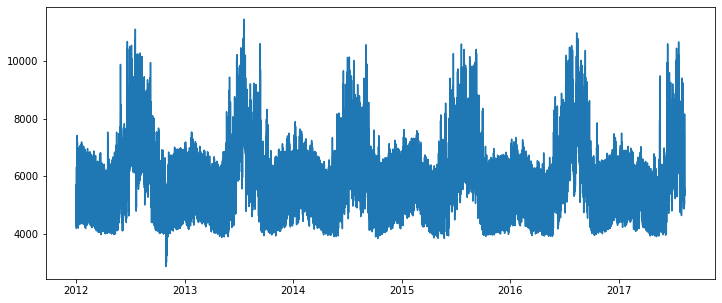

In [10]:
plt.figure(figsize = (12, 5))

plt.plot(df['demand'])
plt.show()

<br/>

## Resampling

The dataset is in hourly level. That means energy consumption of every hour is recorded here. Now we convert it to daily level through resampling.

In [11]:
df = df.resample('D').mean()

#### Shape after Resampling

In [24]:
df.shape

(2051, 3)

<br/>

## After resampling the plot will look like this

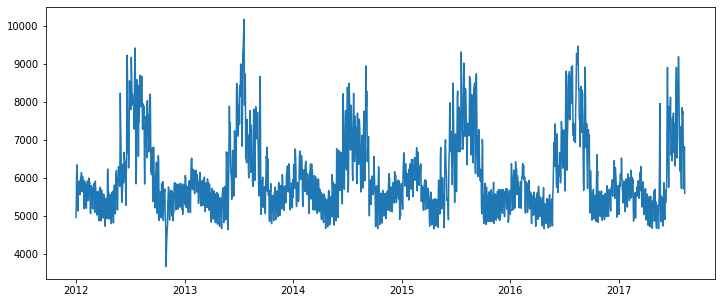

In [12]:
plt.figure(figsize = (12, 5))

plt.plot(df['demand'])
plt.show()

<br/>

## Preparing the dataset for **fbprophet**
Fbprophet prefers two columns named as **ds** and **y**.

In [14]:
df_final = df.reset_index()[['timeStamp', 'demand']].rename({'timeStamp' : 'ds', 'demand' : 'y'}, axis = 'columns')

In [21]:
df_final.head()

,ds,y
0,2012-01-01,4954.833333
1,2012-01-02,5302.954167
2,2012-01-03,6095.512500
3,2012-01-04,6336.266667
4,2012-01-05,6130.245833


<br/>

## splitting into train and test set

In [22]:
train = df_final[(df_final['ds'] >= '2012-01-01') & (df_final['ds'] <= '2017-04-30')]
test = df_final[(df_final['ds'] > '2017-04-30')]

<br/>

#### Lenth of the train and test set

In [23]:
print('Lenth of train set : {}'.format(len(train)))
print('Lenth of test set : {}'.format(len(test)))

Lenth of train set : 1947
Lenth of test set : 104


<br/>

## Train the model

In [25]:
model = Prophet(interval_width = 0.95, yearly_seasonality = True)
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<br/>

## Prediction

In [45]:
future = model.make_future_dataframe(periods = 104)
future.head()

,ds
0,2012-01-01
1,2012-01-02
2,2012-01-03
3,2012-01-04
4,2012-01-05


In [46]:
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [33]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7585.146506,6667.385488,8532.479947
2047,2017-08-09,7574.252310,6691.446699,8425.716642
2048,2017-08-10,7528.960519,6573.471615,8365.735535
2049,2017-08-11,7484.169113,6551.579664,8359.737860
2050,2017-08-12,6909.341600,5968.067988,7827.566518


<br/>

## Plot the actual and predicted values

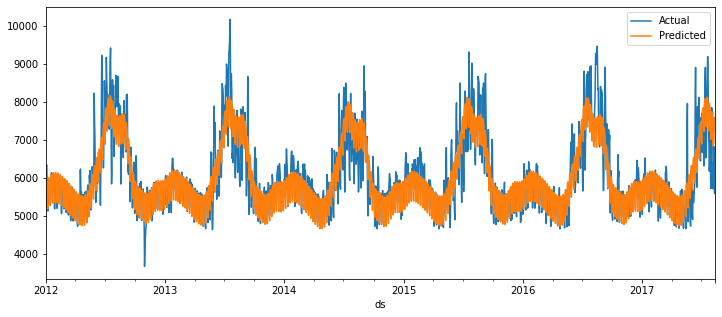

In [42]:
plt.figure(figsize = (12, 5))

df_final.set_index('ds')['y'].plot(label = "Actual")
forecast.set_index('ds')['yhat'].plot(label = "Predicted")

plt.legend()
plt.show()

<br/>

## PLot with confidence interval
**Note:**  
Black dot - actual value  
Shallow blue - lower and higher yhat  
Blue - Predicted values

<Figure size 864x360 with 0 Axes>

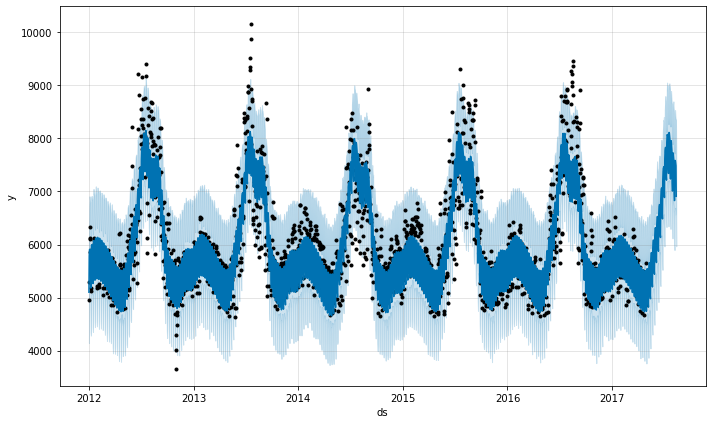

In [44]:
plt.figure(figsize = (12, 5))

model.plot(forecast)
plt.show()

<br/>

## Now let's plot the components of the model

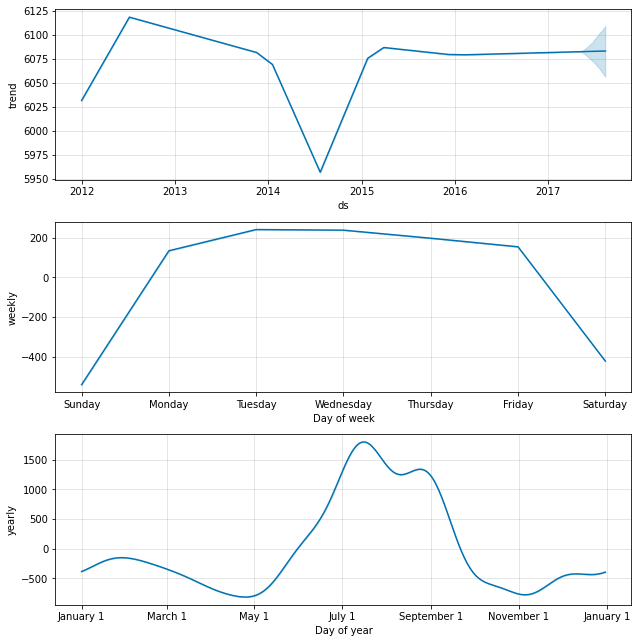

In [48]:
model.plot_components(forecast)
plt.show()

**Note:**  
From the weekly trend, we are seeing that there is no seasonality.  
And from the yearly graph, it is seen that the demand in **May** to **November** is higher than the other months as these are in the summer season in New York City.

<br/>

## Now let's see the changepoints

<Figure size 864x360 with 0 Axes>

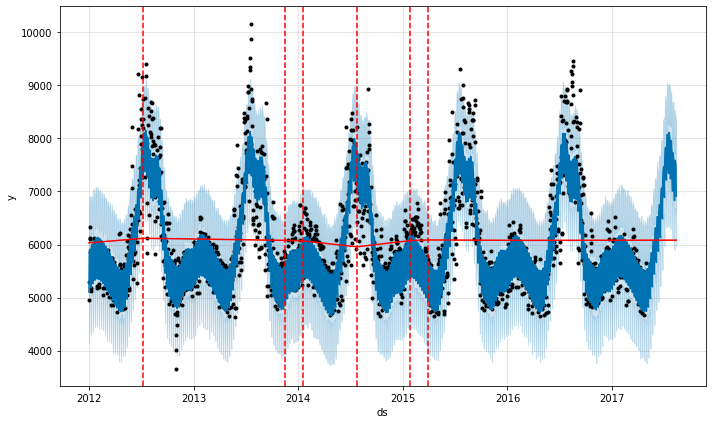

In [51]:
plt.figure(figsize = (12, 5))

chagepoint_fig = model.plot(forecast)
add_changepoints_to_plot(chagepoint_fig.gca(), model, forecast)

plt.show()

<br/>

## Changepoints with time

In [52]:
model.changepoints

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]

<br/>

## Performance Metrics

In [55]:
cv_results = cross_validation( model = model, initial = '731 days', horizon = '365 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,251429.065746,501.427029,405.741907,0.072931,0.065579,0.901099
1,37 days 00:00:00,258154.308609,508.088879,413.132705,0.074218,0.066087,0.895604
2,37 days 12:00:00,260458.355734,510.351208,416.504551,0.074798,0.066775,0.895604
3,38 days 00:00:00,263245.456254,513.074513,419.608202,0.075062,0.067182,0.895604
4,38 days 12:00:00,266934.102525,516.656658,424.824052,0.075894,0.067543,0.895604
...,...,...,...,...,...,...,...
653,363 days 00:00:00,260005.135786,509.906987,446.400124,0.082383,0.081701,0.983516
654,363 days 12:00:00,261690.499217,511.556936,447.442090,0.082567,0.082034,0.978022
655,364 days 00:00:00,266012.437438,515.763936,450.969835,0.083405,0.082787,0.972527
656,364 days 12:00:00,266053.564909,515.803805,450.639292,0.083380,0.082787,0.972527


<br/>
<br/>

**Gratitude: AIEngineering**